# BiciMAD - GeoJSON geospatial data analysis

Copyright © 2017 Javi Ramírez <javi.rmrz@gmail.com> | [@rameerez [tw]](http://twitter.com/rameerez) | [GitHub](http://github.com/rameerez)

This code is Open Source, released under the MIT License.

## Why/what

What does BiciMAD's geospatial data look like? Can we do something valuable with it?

![BiciMAD's geospatial data](img/bicimad-geospatial-data.jpeg)
_Image credit: Fabio Galicia_

## Dataset description

BiciMAD packs GPS track info (the GPS route the user took, including speed data) along with some of their rides instances. They provide this data in GeoJSON format. 

Unfortunately, the GeoJSON stored by BiciMad is not in a valid GeoJSON format :(

 - Single quotes `(')` should be double quotes `(")`
 - A `FeatureCollection` GeoJSON should be of this form:
    ```
    { "type": "FeatureCollection",
      "features": [
      .
      .
      .
     ]}
    ```
    Instead of:
    ```
    {'FeatureCollection': 
        {'Features': [
        ]}
    }
    ```
 - The `features` property should be lowercase
    
Useful links:
 - [GeoJSON specification (RFC7946)](https://tools.ietf.org/html/rfc7946)
 - [Online GeoJSON linter, validator & viewer](http://geojsonlint.com)
 
----

## Global definitions

In [1]:
# Data describing all bike rides
BIKE_RIDES_DATASET = './data/export_20170301_20170406.json'
# Data describing all stations (used just for getting stations' coordinates & names)
STATIONS_DATASET = './data/stations.json'

## Imports & data loading

In [2]:
%matplotlib inline
from pprint import pprint
import json
import pandas as pd
import numpy as np
import math
from pandas.io.json import json_normalize

In [3]:
import geopandas as gpd
import geojsonio

In [4]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson

In [5]:
output_notebook()

Loading BokehJS ...

In [6]:
df = pd.read_json(BIKE_RIDES_DATASET, lines=True)

## GPS tracks analysis

In [7]:
# Lets filter our DataFrame and get a DataFrame only with entries containing a not-NaN "track" property
df_track = df.loc[df.track.notnull()]

In [8]:
df_track

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
115348,{'$oid': '58d18956865e9c3790a34a04'},4,21,60,10,19,{'FeatureCollection': {'Features': [{'type': '...,156725,{'$date': '2017-03-13T12:00:00.000+0100'},fce2be1e9634cbcf37fc6898d12d0dff8732ac0b159f07...,3,
117252,{'$oid': '58d1a814865e9c1d0415cd52'},1,2,71,15,132,{'FeatureCollection': {'Features': [{'type': '...,261831,{'$date': '2017-03-13T16:00:00.000+0100'},ba8ccf63ccc66fc4c28adc621bcc15a3a70286ab3a2480...,3,
129814,{'$oid': '58d181be865e9c3790a32858'},5,7,36,2,36,{'FeatureCollection': {'Features': [{'type': '...,18887,{'$date': '2017-03-14T20:00:00.000+0100'},1c15cc8e667946f44f0a07aaaf529d3737527d04f1c6b4...,1,28009
130571,{'$oid': '58d181be865e9c3790a32857'},4,22,13,22,13,{'FeatureCollection': {'Features': [{'type': '...,12680,{'$date': '2017-03-14T21:00:00.000+0100'},33287e1807327a243dc12ee4d297ef8f56940992257c63...,1,28005
130574,{'$oid': '58d181e8865e9c3790a32901'},4,5,49,10,40,{'FeatureCollection': {'Features': [{'type': '...,18043,{'$date': '2017-03-14T21:00:00.000+0100'},ea67a1693aabf82860de4c3eda49ea95dd0939e17b3d21...,1,28047
131154,{'$oid': '58d181f0865e9c3790a32925'},3,10,121,4,149,{'FeatureCollection': {'Features': [{'type': '...,15125,{'$date': '2017-03-14T22:00:00.000+0100'},0e203142eb42fa7178db31ec80aba50695d3408c2872ba...,1,28008
131156,{'$oid': '58d181f5865e9c3790a3293c'},4,9,160,9,19,{'FeatureCollection': {'Features': [{'type': '...,17864,{'$date': '2017-03-14T22:00:00.000+0100'},8ad7e45dc1603c71cd29397bec6fd0cbe785d3de791ff7...,1,28004
131500,{'$oid': '58d181c3865e9c3790a3286b'},4,20,1,11,77,{'FeatureCollection': {'Features': [{'type': '...,6859,{'$date': '2017-03-14T23:00:00.000+0100'},3ec89a8148c0b835cace234fcc38ddd3a2561d1068a3f4...,3,
131813,{'$oid': '58d181b7865e9c3790a3283c'},4,24,29,23,149,{'FeatureCollection': {'Features': [{'type': '...,1853,{'$date': '2017-03-15T00:00:00.000+0100'},2a192bd4ccebe687f6af157215a528f0c549f0e603455b...,1,28005
131814,{'$oid': '58d181b8865e9c3790a32841'},3,15,137,4,43,{'FeatureCollection': {'Features': [{'type': '...,1690,{'$date': '2017-03-15T00:00:00.000+0100'},5e0c3f0a0ccc690c35de9056c24afc44e0f7702cb0c8f4...,1,28026


## Converting JSONs into valid GeoJSONs

In [9]:
df_with_tracks = df_track.copy()

In [10]:
def sanitize_geojson(row):
    geojson_features = row["track"]["FeatureCollection"]["Features"]
    valid_geojson = {}
    valid_geojson["type"] = "FeatureCollection"
    valid_geojson["features"] = geojson_features
    return valid_geojson

In [11]:
df_with_tracks["GeoJSON"] = df_with_tracks.apply(sanitize_geojson, axis=1)

Yay! We have now a dataframe containing valid GeoJSONs. Let's have a look:

In [12]:
df_with_tracks.sort_values(by=['travel_time'], ascending=False)[["user_type", "travel_time", "GeoJSON"]]

,user_type,travel_time,GeoJSON
148394,3,584055,"{'type': 'FeatureCollection', 'features': [{'t..."
132725,3,522803,"{'type': 'FeatureCollection', 'features': [{'t..."
166176,3,517185,"{'type': 'FeatureCollection', 'features': [{'t..."
158909,3,501398,"{'type': 'FeatureCollection', 'features': [{'t..."
158907,3,500632,"{'type': 'FeatureCollection', 'features': [{'t..."
145025,3,427285,"{'type': 'FeatureCollection', 'features': [{'t..."
143097,3,402740,"{'type': 'FeatureCollection', 'features': [{'t..."
210757,3,347624,"{'type': 'FeatureCollection', 'features': [{'t..."
213588,3,345882,"{'type': 'FeatureCollection', 'features': [{'t..."
213587,3,342724,"{'type': 'FeatureCollection', 'features': [{'t..."


There's more columns, obviously, but that's our GeoJSONs sorted by travel_time.

Since the first ones, the longest ones, belong only to mantainance purposes (user_type = 3), let's filter by user_type and get only annual pass holders' tracks.

In [13]:
df_with_tracks[df_with_tracks['user_type'] == 1].sort_values(by=['travel_time'], ascending=False).iloc[1600]["GeoJSON"]

{'features': [{'geometry': {'coordinates': [-3.6840577999999997,
     40.4262994997222],
    'type': 'Point'},
   'properties': {'secondsfromstart': 4521,
    'speed': 7.27,
    'var': '28001,ES,Madrid,Madrid,CALLE VELAZQUEZ 42,Madrid'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-3.6843165997222203, 40.4225665],
    'type': 'Point'},
   'properties': {'secondsfromstart': 4462,
    'speed': 7.11,
    'var': '28001,ES,Madrid,Madrid,CALLE VELAZQUEZ 12,Madrid'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-3.68222249972222, 40.4212747997222],
    'type': 'Point'},
   'properties': {'secondsfromstart': 4402,
    'speed': 3.36,
    'var': "28009,ES,Madrid,Madrid,CALLE O'DONNELL,Madrid"},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-3.6805816, 40.4187574997222],
    'type': 'Point'},
   'properties': {'secondsfromstart': 4342,
    'speed': 6.38,
    'var': '28009,ES,Madrid,Madrid,PASEO FERNAN NU�EZ,Madrid'},
   'type': 'Feature'},
  {'geometry': {'coordinate

## Visualizing an individual GeoJSON
What does this geospatial data look like?

In [14]:
dfg = gpd.read_file('geojson-example.json')

In [15]:
dfg

,secondsfromstart,speed,var,geometry
0,4521,7.27,"28001,ES,Madrid,Madrid,CALLE VELAZQUEZ 42,Madrid",POINT (-3.6840578 40.4262994997222)
1,4462,7.11,"28001,ES,Madrid,Madrid,CALLE VELAZQUEZ 12,Madrid",POINT (-3.68431659972222 40.4225665)
2,4402,3.36,"28009,ES,Madrid,Madrid,CALLE ODONNELL,Madrid",POINT (-3.68222249972222 40.4212747997222)
3,4342,6.38,"28009,ES,Madrid,Madrid,PASEO FERNAN NU�EZ,Madrid",POINT (-3.6805816 40.4187574997222)
4,4282,4.33,"28009,ES,Madrid,Madrid,PASEO FERNAN NU�EZ,Madrid",POINT (-3.6794983 40.4148162997222)
5,4222,5.69,"28009,ES,Madrid,Madrid,PASEO URUGUAY,Madrid",POINT (-3.67827109972222 40.4120331)
6,4163,5.77,"28007,ES,Madrid,Madrid,AVDA MENENDEZ PELAYO 75...",POINT (-3.67673909972222 40.4105125997222)
7,4103,1.55,"28007,ES,Madrid,Madrid,CALLE CONDE DE CARTAGEN...",POINT (-3.6758985 40.4087656)
8,4043,5.91,"28007,ES,Madrid,Madrid,CALLE ANTONIO DIAZ-CA�A...",POINT (-3.6733608 40.4075060997222)
9,3984,2.22,"28007,ES,Madrid,Madrid,PLAZA CONDE DE CASAL,Ma...",POINT (-3.67034279972222 40.4062478)


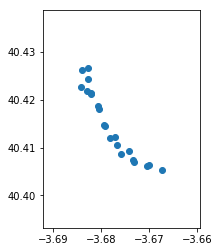

In [24]:
dfg.plot()

`geojsonio` not working properly. It will redirect to geojson.io instead of embedding an iframe in the notebook. Problem described [here](https://github.com/jwass/geojsonio.py/issues/6). Inserting an image instead:
![BiciMAD GeoJSON](img/bicimad-geojson.png)
So, as we can see, we have a bunch of geo **points**. We need to find a way to convert those into actual **tracks**.

## From individual GeoJSONs to a huuuuge array of features

Work in progress... this part may not work at all

In [87]:
starting_string = '''{
  "type": "FeatureCollection", '''

with open("test.txt", "a") as myfile:
    myfile.write(starting_string)

In [85]:
def append_row_features_to_file(row)
    geojson_features = row["GeoJSON"]["Features"]
    features_string = ''' "features": ''' + str(geojson_features).replace('\'', '\"')   

# ⚠️ Work in progress! ⚠️

## To-do:

- Find suitable library to plot GeoJSONs (geojsonio? Use an external website and just use JavaScript?)
- Find a way to convert from geo points to actual tracks (as lines)
- Find a way to plot every track into a map
- Streets with most traffic (heatmap?)
- Overlap known bike lanes and see if there is unused lanes / streets needing bike lanes - is Madrid bike-friendly?
- Are there "blind spots"? i.e.: parts of the city needing a station / service coverage?